In [1]:
from pathlib import Path
import pickle

import numpy as np
from datasets import load_dataset
from tqdm.auto import tqdm
from scipy.special import log_softmax
import IPython.display
from typing import Any

import os
from pathlib import Path
import time
import json

import torch
from datasets import load_dataset, Audio
import IPython.display
import librosa
from pyannote.audio import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dataset = load_dataset('yodas2_ru000_32k', data_files='*.parquet', split='train')
dataset

Resolving data files:   0%|          | 0/456 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/456 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'video_id', 'duration', 'audio', 'utterances', 'ast', 'segments', 'speaker_embeddings'],
    num_rows: 30574
})

In [29]:
samples = [x for x in tqdm(dataset.take(500))]

  0%|          | 0/500 [00:00<?, ?it/s]

In [30]:
for sample in samples:
    sample['speaker_embeddings'] = np.array(sample['speaker_embeddings'])

In [33]:
def reorder_speakers_inplace(sample: dict[str, Any]):
    if len(sample['segments']) == 0:
        return
    speakers_new_ids = (
        pd.DataFrame(sample['segments'])
        .set_index('speaker_idx')
        .assign(duration=lambda df: df.end - df.start)
        .groupby('speaker_idx')['duration']
        .sum()  # to series, total speech time for each speaker_idx
        .sort_index()
        .rank(method='first', ascending=False)
        .astype(int)
        .values  # to numpy array
        - 1  # .rank() enumerates from 1, we need to enumerate from 0
    )
    for segment in sample['segments']:
        segment['speaker_idx'] = speakers_new_ids[segment['speaker_idx']]
    sample['speaker_embeddings'] = [np.argsort(speakers_new_ids)]

for sample in samples:
    reorder_speakers_inplace(sample)

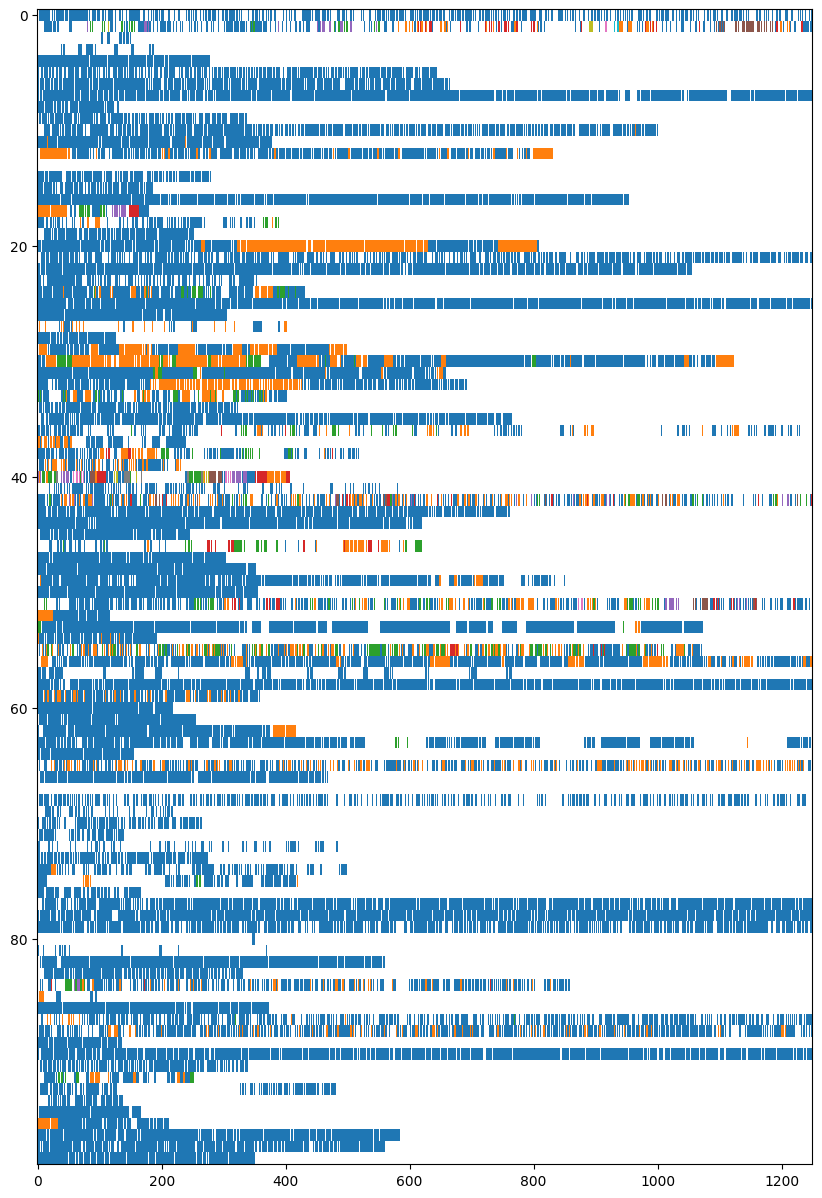

In [34]:
def get_speakers_mask(sample: dict[str, Any]) -> np.ndarray:
    arr = np.full(round(sample['duration']), np.nan)
    for segment in sample['segments']:
        arr[round(segment['start']):round(segment['end'])] = segment['speaker_idx']
    return arr

def pad_or_trim_to_len(arr: np.ndarray, length: int, value: float = np.nan):
    # pad 1D array
    pad_size = length - len(arr)
    if pad_size > 0:
        return np.concatenate([arr, np.full(pad_size, value)])
    else:
        return arr[:length]

masks = np.stack([
    pad_or_trim_to_len(get_speakers_mask(s), 1250)
    for s in samples
    if s['duration'] > 120
])

plt.figure(figsize=(10, 15))
plt.imshow(np.clip(masks, 0, 10)[:100], aspect='auto', cmap='tab10', interpolation='none', vmin=0, vmax=9)
plt.show()